In [1]:
import tomotopy as tp
import pandas as pd
import numpy as np
import sys
import nltk
import pickle
import random
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re

### 1. Load the model and the abstracts file 

In [2]:
models = []
names = ['LDAbatch1.bin','LDAbatch2.bin','LDAbatch3.bin','LDAbatch4.bin']
for name in names:
    models.append(tp.LDAModel.load(name))

In [56]:
normalised = pickle.load(open( "collection_cleaned.p", "rb" ))

In [58]:
SEED = 11
random.seed(SEED)
random.shuffle(normalised)

### 3. Extract topics for each document 


In [7]:
def get_top_topics(document, model, min_score=0.8):
    """ 
    Extracting top n topics for each document. 
    Selects the n most likely topics whose p(topic|document) sum to min_score.
    """
    # inserting the document in the model
    new_doc = model.make_doc(document)
    _,_ = model.infer(new_doc)
    # ordering from most probable topic to least one 
    dist = new_doc.get_topic_dist()
    indices = np.flip(np.argsort(dist))
    score = 0
    indices_kept = []
    probs_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        indices_kept.append(index)
        probs_kept.append(dist[index])
    return list(zip(indices_kept, probs_kept))

In [8]:
docs2topics = []
num_batches = 4
batches = np.array_split(normalised, num_batches)

for i,model in enumerate(models):
    print("Working on batch "+str(i))
    batch = batches[i].tolist()
    docs2topics.append([get_top_topics(doc, model) for doc in batch])

Working on batch 0
Working on batch 1
Working on batch 2
Working on batch 3


In [9]:
docs2topics_flat = [item for sublist in docs2topics for item in sublist]
len(docs2topics_flat)

20494

In [10]:
def get_batch_indices(batches):
    res = []
    for i,batch in enumerate(batches):
        res += [i]*len(batch)
    return res
batch_indices = get_batch_indices(batches)

In [11]:
print(batch_indices[1000])
print(batch_indices[6000])
print(batch_indices[11000])
print(batch_indices[16000])

0
1
2
3


In [12]:
len(batch_indices)

20494

In [67]:
data = pd.read_csv("abstracts_eng.csv")

In [68]:
data.head()

,abstract,id,title
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...
1,We will review a Lemma published by Ran Raz in...,188623.0,Some remarks on a lemma of Ran Raz
2,China’s growing influence in Europe has the po...,346708.0,China as a Stress Test for Europe’s Coherence
3,Nowhere is China's Belt and Road Initiative (B...,346709.0,"On the Belt, on the Road: China’s Pivot to Eur..."
4,Passenger transit modes typical of the urban s...,187461.0,Applications and Future Developments: Modellin...


In [69]:
# Before merging the two files we need to match them 
# Here we're going to build the list of indices of the "normalised" collection with respect to 
# the "data" collection 
random.seed(SEED)
indices = list(range(0,len(normalised)))
random.shuffle(indices)

In [70]:
data.iloc[indices[0]]["abstract"][0:300]

'Introduction  A common drawback of many anticancer therapies is non-specificity in action of killing. We investigated the potential of ultra-low intensity and frequency pulsed electromagnetic fields (PEMFs) to kill breast cancer cells. Our criteria to accept this technology as a potentially valid th'

In [71]:
" ".join(normalised[0][0:100])

'introduct common drawback mani anticanc therapi non specif action kill investig potenti ultra low intens frequenc pul electromagnet field pemf kill breast cancer cell criterion accept technolog potenti valid therapeut approach cytotox breast cancer cell design field prove innocu healthi cell class would expo pemf clinic treatment method mcf breast cancer cell normal counterpart mcf cell expo pemf cytotox indic measur order design pemf paradigm best kill breast cancer cell pemf paramet test frequenc rang hz intens rang mt mt exposur durat rang minut per day three day determin optimum paramet select cancer cell kill result observ discret window vulner'

In [72]:
enriched = data.iloc[indices]
enriched["topics"] = docs2topics_flat
enriched["batchID"] = batch_indices


/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
enriched.head(3)

,abstract,id,title,topics,batchID
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"[(72, 0.13636331), (27, 0.102346666), (44, 0.0...",0
9676,A global pigment database consisting of 37103 ...,311911.0,The MAREDAT global database of high performanc...,"[(25, 0.19064094), (112, 0.095547974), (38, 0....",0
3395,"The transition metal dipnictides TaAs2, TaSb2,...",287331.0,Hidden Weyl points in centrosymmetric paramagn...,"[(116, 0.13356043), (108, 0.10108282), (55, 0....",0


In [74]:
# exploding the dataframe (one row for each document-topic pair)
enriched=enriched.explode("topics")
enriched.columns = ["abstract","publication_id","publication_title","topic","batch_id"]

In [75]:
enriched.head(3)

,abstract,publication_id,publication_title,topic,batch_id
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(72, 0.13636331)",0
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(27, 0.102346666)",0
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(44, 0.09340515)",0


In [76]:
# separate topic id and probability

enriched[["topic_id","topic_probability"]] = pd.DataFrame(enriched["topic"].tolist(), 
                                                          index=enriched.index)
enriched.head()

,abstract,publication_id,publication_title,topic,batch_id,topic_id,topic_probability
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(72, 0.13636331)",0,72,0.136363
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(27, 0.102346666)",0,27,0.102347
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(44, 0.09340515)",0,44,0.093405
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(50, 0.085035846)",0,50,0.085036
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,"(87, 0.077362314)",0,87,0.077362


In [77]:
enriched = enriched.drop(["topic"], axis = 1)
enriched.head(3)

,abstract,publication_id,publication_title,batch_id,topic_id,topic_probability
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,0,72,0.136363
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,0,27,0.102347
15476,Introduction A common drawback of many antica...,252060.0,Low Intensity and Frequency Pulsed Electromagn...,0,44,0.093405


In [78]:
# issue: quotes need to be escaped in neo4j
# the following function helps us avoid errors when importing

def add_quote(abstract):
    if isinstance(abstract, str):
        abstract = abstract.replace('\\"', '""')
        return abstract.replace('"', '""')

enriched["abstract"] = enriched["abstract"].apply(add_quote)

In [105]:
# save to .csv 
file_name="abstract+topic.csv"
enriched.to_csv(file_name,index=False)

### 4. Extract words for each topic

In [79]:
def get_top_words(topic, model, min_score=0.8):
    """
    Extracting top n words for each document. 
    Selects the n most likely words whose p(word|topic) sum to min_score.
    """
    dist = model.get_topic_word_dist(topic)
    indices = np.flip(np.argsort(dist))
    score = 0
    word_kept = []
    word_prob_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        word_kept.append(model.used_vocabs[index])
        word_prob_kept.append(dist[index])
    return list(zip(word_kept, word_prob_kept))

In [80]:
# trying it out
#get_top_words(2, model, 0.25)

In [81]:
num_topics = 125

In [82]:
topics2words = []
for i,model in enumerate(models): # note: preserving the order is extremely important here 
    print("Working on batch "+str(i))
    topics2words += [get_top_words(i, model, min_score=0.25) for i in range(num_topics)]

Working on batch 0
Working on batch 1
Working on batch 2
Working on batch 3


In [83]:
len(topics2words)

500

In [84]:
topic_ids = list(range(num_topics))*4
len(topic_ids)

500

In [85]:
topics_batch_indices = [0]*125+[1]*125+[2]*125+[3]*125
len(topics_batch_indices)

500

In [86]:
# creating new topic dataframe
topics_df = pd.DataFrame({"TopicID":topic_ids,"BatchID":topics_batch_indices,"TopicWords":topics2words})

In [87]:
topics_df.head(3)

,TopicID,BatchID,TopicWords
0,0,0,"[(lca, 0.026345199), (multi, 0.024031073), (sp..."
1,1,0,"[(plan, 0.023429058), (methodolog, 0.017115565..."
2,2,0,"[(hospit, 0.053965636), (sb, 0.03744605), (spl..."


In [91]:
topics_exploded = topics_df.explode("TopicWords")

In [92]:
topics_exploded.head()

,TopicID,BatchID,TopicWords
0,0,0,"(lca, 0.026345199)"
0,0,0,"(multi, 0.024031073)"
0,0,0,"(spar, 0.021150842)"
0,0,0,"(convex, 0.020347305)"
0,0,0,"(environment, 0.02008556)"


In [93]:
topics_exploded[["word","word_probability"]] = pd.DataFrame(topics_exploded["TopicWords"].tolist(), 
                                                          index=topics_exploded.index)
topics_exploded.head()

,TopicID,BatchID,TopicWords,word,word_probability
0,0,0,"(lca, 0.026345199)",lca,0.026345
0,0,0,"(multi, 0.024031073)",multi,0.024031
0,0,0,"(spar, 0.021150842)",spar,0.021151
0,0,0,"(convex, 0.020347305)",convex,0.020347
0,0,0,"(environment, 0.02008556)",environment,0.020086


In [100]:
topics_exploded = topics_exploded.drop(["TopicWords"], axis = 1)
topics_exploded.head(3)

,TopicID,BatchID,word,word_probability
0,0,0,lca,0.026345
0,0,0,multi,0.024031
0,0,0,spar,0.021151


In [102]:
# save to .csv 
file_name="topics.csv"
topics_df.to_csv(file_name,index=False)

In [104]:
# save words to .csv
file_name = "words.csv"
topics_exploded.to_csv(file_name, index=False)

In [20]:
# save to .json
# note: this one we have to save to json in order to save the list format 
file_name="topics.json"
topics_df.to_json(file_name, orient = "records")

### Export to Neo4j

Topic nodes: 
- TopicID (long)
- Words (list(str)) 
<br>
<br>

        #Adding abstracts to existing publications
        #LOAD CSV WITH HEADERS FROM "file:///abstract+topic.csv" AS line
        #WITH line WHERE line.publication_id IS NOT NULL
        #MATCH (publication:Publication {title: line.publication_title})
        #SET publication.abstract = line.abstract;
        
        #Defining the topic nodes
        CREATE CONSTRAINT ON (t:Topic) ASSERT (t.ID, t.batchID) IS NODE KEY;
        
        #Loading the topic nodes from CSV
        LOAD CSV WITH HEADERS FROM "file:///topics.csv" AS line
        WITH line where line.TopicID IS NOT NULL
        MERGE (t: Topic {ID: line.TopicID, batchID: line.BatchID})
        SET t.words= line.TopicWords;
        
        #Loading the topic nodes from JSON
        CALL apoc.load.json("file:///topics.json")
        YIELD value
        MERGE (t:Topic {ID: value.TopicID, batchID: value.BatchID})
        SET t.words = value.TopicWords;

        #Loading document<->topic relationships
        LOAD CSV WITH HEADERS FROM "file:///abstract+topic.csv" AS line
        MATCH (p:Publication {title: line.publication_title}),
               (t:Topic {ID:line.topic_id, batchID: line.batch_id})
        MERGE (p)-[r:IS_ABOUT {weight: round(1000 * toFloat(line.topic_probability)) / 1000}]->(t);
        
        #Constraint on word nodes being unique
        CREATE CONSTRAINT ON (c:Word) ASSERT c.name IS UNIQUE;
        
        #Loading the word nodes from CSV
        LOAD CSV WITH HEADERS FROM "file:///words.csv" AS line
        WITH line where line.word IS NOT NULL
        MERGE (w: Word{name: line.word});
        
        #Loading word<->topic relationships
        LOAD CSV WITH HEADERS FROM "file:///words.csv" AS line
        MATCH (t: Topic {ID: line.TopicID, batchID: line.BatchID}),
                (w: Word {name: line.word})
        MERGE (w)-[r:IS_IN {weight: round(1000 * toFloat(line.word_probability)) / 1000}]->(t);

### 5. Visualizations

Here we use the docs2topics and topics2words data extracted before to get nice visualisations of our collection 

In [46]:
topic_df = pd.read_csv("topics.csv")
topic_df.head()

,TopicID,TopicWords
0,0,"['flow', 'fluid', 'transport', 'pressur', 'vel..."
1,1,"['frequenc', 'nois', 'signal', 'oscil', 'pul',..."
2,2,"['tc', 'spectrum', 'peak', 'ce', 'ab', 'spectr..."
3,3,"['integr', 'comput', 'loop', 'order', 'correct..."
4,4,"['channel', 'capac', 'receiv', 'sourc', 'input..."


In [71]:
def process_topic(ls):
    return ls.strip("][").replace("'","").split(', ')

In [74]:
topics2words = list(topic_df["TopicWords"].apply(process_topic))

In [40]:
# topic sparsity measure of our documents
docs2num_topics = [len(ts) for ts in docs2topics]

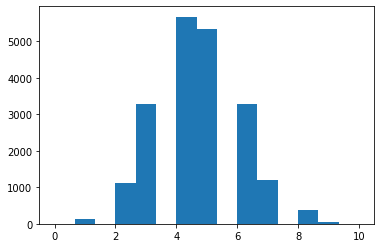

In [57]:
import matplotlib.pyplot as plt
h = plt.hist(docs2num_topics, bins=15, range=(0,10))
plt.show(h)

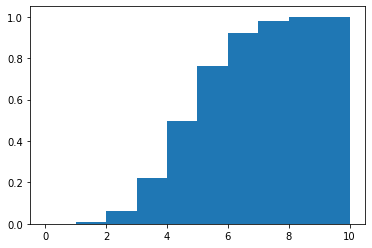

In [58]:
h = plt.hist(docs2num_topics, bins=10, range=(0,10), density=True, cumulative=True)
plt.show(h)

In [77]:
# word sparsity measure of our topics
topics2num_words = [len(ts) for ts in topics2words]

In [78]:
set(topics2num_words)

{2,
 3,
 5,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45}

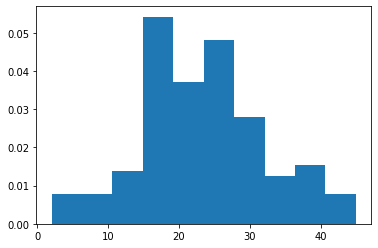

In [80]:
import matplotlib.pyplot as plt
h2 = plt.hist(topics2num_words, density = True)
plt.show(h2)

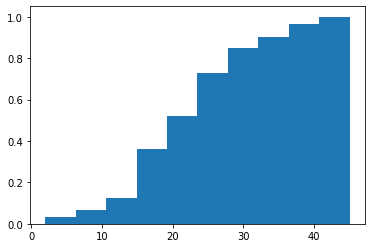

In [81]:
h3 = plt.hist(topics2num_words, density=True, cumulative=True)
plt.show(h3)